## LINEAR REGRESSION

In [35]:
#set environment
import os
import sys
 
os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.4-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [36]:
#Creating sparksession 
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [37]:
#import Sparksession driver
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Reg Car Price Dataset") \
    .getOrCreate()

In [38]:
#import csv
df = spark.read.csv('data/cardata_preprocessed.csv',header=True,inferSchema=True)
df.show(3)


+----+-----------------+---------+------------+----------+-------+------+-----+-----+-----+
|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|Mileage|Engine|Power|Seats|Price|
+----+-----------------+---------+------------+----------+-------+------+-----+-----+-----+
|2010|            72000|      CNG|      Manual|     First|   26.6| 998.0|58.16|  5.0| 1.75|
|2015|            41000|   Diesel|      Manual|     First|  19.67|1582.0|126.2|  5.0| 12.5|
|2011|            46000|   Petrol|      Manual|     First|   18.2|1199.0| 88.7|  5.0|  4.5|
+----+-----------------+---------+------------+----------+-------+------+-----+-----+-----+
only showing top 3 rows



In [39]:
for col in df.columns:
    print("no. of cells in column", col, "with null values:", df.filter(df[col].isNull()).count())

no. of cells in column Year with null values: 0
no. of cells in column Kilometers_Driven with null values: 0
no. of cells in column Fuel_Type with null values: 0
no. of cells in column Transmission with null values: 0
no. of cells in column Owner_Type with null values: 0
no. of cells in column Mileage with null values: 0
no. of cells in column Engine with null values: 0
no. of cells in column Power with null values: 0
no. of cells in column Seats with null values: 0
no. of cells in column Price with null values: 0


In [40]:
#SQL like schema
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Kilometers_Driven: integer (nullable = true)
 |-- Fuel_Type: string (nullable = true)
 |-- Transmission: string (nullable = true)
 |-- Owner_Type: string (nullable = true)
 |-- Mileage: double (nullable = true)
 |-- Engine: double (nullable = true)
 |-- Power: double (nullable = true)
 |-- Seats: double (nullable = true)
 |-- Price: double (nullable = true)



In [41]:
#count number of records in the df
df.count()

5872

In [42]:
#Label encoder
from pyspark.ml.feature import StringIndexer
indexed = df
for col in df.columns:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col+"_encoded")
    indexed = stringIndexer.fit(indexed).transform(indexed)
indexed.show(2)

+----+-----------------+---------+------------+----------+-------+------+-----+-----+-----+------------+-------------------------+-----------------+--------------------+------------------+---------------+--------------+-------------+-------------+-------------+
|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|Mileage|Engine|Power|Seats|Price|Year_encoded|Kilometers_Driven_encoded|Fuel_Type_encoded|Transmission_encoded|Owner_Type_encoded|Mileage_encoded|Engine_encoded|Power_encoded|Seats_encoded|Price_encoded|
+----+-----------------+---------+------------+----------+-------+------+-----+-----+-----+------------+-------------------------+-----------------+--------------------+------------------+---------------+--------------+-------------+-------------+-------------+
|2010|            72000|      CNG|      Manual|     First|   26.6| 998.0|58.16|  5.0| 1.75|         7.0|                     17.0|              2.0|                 0.0|               0.0|          141.0|          

In [43]:
#one hot encoding on few variables with more than two levels
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol="Fuel_Type_encoded",outputCol="Fuel_Type_vec",dropLast=True)
encoded = encoder.transform(indexed)
encoded.show(2)

from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol="Owner_Type_encoded",outputCol="Owner_Type_vec",dropLast=True)
encoded = encoder.transform(encoded)
encoded.show(2)

+----+-----------------+---------+------------+----------+-------+------+-----+-----+-----+------------+-------------------------+-----------------+--------------------+------------------+---------------+--------------+-------------+-------------+-------------+-------------+
|Year|Kilometers_Driven|Fuel_Type|Transmission|Owner_Type|Mileage|Engine|Power|Seats|Price|Year_encoded|Kilometers_Driven_encoded|Fuel_Type_encoded|Transmission_encoded|Owner_Type_encoded|Mileage_encoded|Engine_encoded|Power_encoded|Seats_encoded|Price_encoded|Fuel_Type_vec|
+----+-----------------+---------+------------+----------+-------+------+-----+-----+-----+------------+-------------------------+-----------------+--------------------+------------------+---------------+--------------+-------------+-------------+-------------+-------------+
|2010|            72000|      CNG|      Manual|     First|   26.6| 998.0|58.16|  5.0| 1.75|         7.0|                     17.0|              2.0|                 0.0|   

In [44]:
#all the independent variables need to be packed into one column of vector type
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["Kilometers_Driven","Fuel_Type_vec","Transmission_encoded",
                                       "Owner_Type_vec","Mileage","Engine","Power","Seats"], 
                            outputCol="features")
feature_vec=assembler.transform(encoded)
feature_vec.select("features").show(5)
df = feature_vec.select(['features','Price'])
df.show(3)

+--------------------+
|            features|
+--------------------+
|[72000.0,0.0,0.0,...|
|[41000.0,1.0,0.0,...|
|[46000.0,0.0,1.0,...|
|[87000.0,1.0,0.0,...|
|[40670.0,1.0,0.0,...|
+--------------------+
only showing top 5 rows

+--------------------+-----+
|            features|Price|
+--------------------+-----+
|[72000.0,0.0,0.0,...| 1.75|
|[41000.0,1.0,0.0,...| 12.5|
|[46000.0,0.0,1.0,...|  4.5|
+--------------------+-----+
only showing top 3 rows



In [45]:
#Standard scaling for data
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [46]:
scaler_model = scaler.fit(feature_vec)

In [47]:
scaled_data = scaler_model.transform(feature_vec)

In [48]:
#import PCA 
from pyspark.ml.feature import PCA
pca = PCA(k=5, inputCol='features', outputCol='features_pca')

In [49]:
#Pca model on feature vector
pca_model = pca.fit(feature_vec)


In [50]:
pca_data = pca_model.transform(feature_vec).select('features_pca')
pca_data.show(3)


+--------------------+
|        features_pca|
+--------------------+
|[-72000.593845961...|
|[-41000.955575883...|
|[-46000.721331342...|
+--------------------+
only showing top 3 rows



In [51]:
#concatenating label column to feature_pca columns
from pyspark.sql.functions import concat
from pyspark.sql.functions import col
res = df.withColumn("Price",concat(col("Price")))
res.show(5)


+--------------------+-----+
|            features|Price|
+--------------------+-----+
|[72000.0,0.0,0.0,...| 1.75|
|[41000.0,1.0,0.0,...| 12.5|
|[46000.0,0.0,1.0,...|  4.5|
|[87000.0,1.0,0.0,...|  6.0|
|[40670.0,1.0,0.0,...|17.74|
+--------------------+-----+
only showing top 5 rows



In [52]:
#
from pyspark.sql.functions import monotonically_increasing_id 
df = df.withColumn("row_id", monotonically_increasing_id())
pca_data = pca_data.withColumn("row_id", monotonically_increasing_id())
result_df = df.join(pca_data, ("row_id")).drop("row_id")
result_df.show()

+--------------------+-----+--------------------+
|            features|Price|        features_pca|
+--------------------+-----+--------------------+
|[72000.0,0.0,0.0,...| 1.75|[-72000.593845961...|
|[41000.0,1.0,0.0,...| 12.5|[-41000.955575883...|
|[46000.0,0.0,1.0,...|  4.5|[-46000.721331342...|
|[87000.0,1.0,0.0,...|  6.0|[-87000.743516365...|
|[40670.0,1.0,0.0,...|17.74|[-40671.190348170...|
|(12,[0,5,8,9,10,1...| 2.35|[-75000.481509463...|
|[86999.0,1.0,0.0,...|  3.5|[-86999.872357875...|
|[36000.0,1.0,0.0,...| 17.5|[-36001.669757758...|
|[64430.0,1.0,0.0,...|  5.2|[-64430.960522398...|
|[65932.0,1.0,0.0,...| 1.95|[-65932.747111100...|
|[25692.0,0.0,1.0,...| 9.95|[-25692.885071442...|
|[60000.0,0.0,1.0,...| 4.49|[-60000.900262440...|
|[64424.0,1.0,0.0,...|  5.6|[-64424.747380597...|
|[72000.0,1.0,0.0,...| 27.0|[-72001.313627025...|
|[85000.0,1.0,0.0,...| 17.5|[-85001.309840834...|
|[110000.0,1.0,0.0...| 15.0|[-110001.48734511...|
|[58950.0,1.0,0.0,...|  5.4|[-58950.900692414...|


In [53]:
#dropping insignificant features
result_df = result_df.drop("features")
result_df.show(5)

+-----+--------------------+
|Price|        features_pca|
+-----+--------------------+
| 1.75|[-72000.593845961...|
| 12.5|[-41000.955575883...|
|  4.5|[-46000.721331342...|
|  6.0|[-87000.743516365...|
|17.74|[-40671.190348170...|
+-----+--------------------+
only showing top 5 rows



In [54]:
# Split the data into train and test sets
train_data, test_data = result_df.randomSplit([.75,.25],seed=0)
train_data.show(3)

+-----+--------------------+
|Price|        features_pca|
+-----+--------------------+
| 0.45|[-95150.586598699...|
| 0.45|[-86000.800079386...|
|  0.5|[-57000.369037015...|
+-----+--------------------+
only showing top 3 rows



In [55]:
#import linear regression model
from pyspark.ml.regression import LinearRegression
# Create initial LinearRegression model
lr = LinearRegression(labelCol="Price", featuresCol="features_pca",  
                        maxIter=10, regParam=0.0001,  
                        elasticNetParam=0.0)
#fit linear regression model on training data
lrModel = lr.fit(train_data)
predictions = lrModel.transform(test_data)
predictions.printSchema()
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

root
 |-- Price: double (nullable = true)
 |-- features_pca: vector (nullable = true)
 |-- prediction: double (nullable = true)

Coefficients: [4.510033936352438e-05,-0.013058370908925077,-0.15117953552801666,-0.28632146315410195,0.4826898890894985]
Intercept: -15.627293206849307


In [56]:
#Accuracy Metrics R2 & RMSE
trainingSummary = lrModel.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 6.746636
r2: 0.640053


In [57]:
#Conclusion : RMSE: 6.746636 & r2: 0.640053 for data.

## RANDOM FOREST

In [58]:
#immport random forest regressor
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features",labelCol="Price")

In [59]:
# Split the data into train and test sets
train_data, test_data = df.randomSplit([.75,.25],seed=0)

In [60]:
model = rf.fit(train_data)

In [61]:
predictions = model.transform(test_data)

In [62]:
predictions.show(5)

+--------------------+-----+------+------------------+
|            features|Price|row_id|        prediction|
+--------------------+-----+------+------------------+
|(12,[0,1,8,9,10,1...| 2.15|  3281| 4.251886388895171|
|(12,[0,1,8,9,10,1...|  4.0|    29| 7.771098672125601|
|(12,[0,2,5,9,10,1...| 2.45|  1029| 2.923659867281364|
|(12,[0,6,8,9,10,1...| 1.65|  2221|2.2895294268486404|
|[171.0,0.0,1.0,0....|  3.6|  1323|3.2970135861256735|
+--------------------+-----+------+------------------+
only showing top 5 rows



In [63]:
#Accuracy metrics RMSE
from pyspark.ml.evaluation import RegressionEvaluator
rfevaluator = RegressionEvaluator(labelCol="Price",predictionCol="prediction",metricName="rmse")
print("Root Mean Squared Error on test data",rfevaluator.evaluate(predictions))


Root Mean Squared Error on test data 5.327260398963604


In [64]:
#Accuracy metrics R2
from pyspark.ml.evaluation import RegressionEvaluator
rfevaluator = RegressionEvaluator(labelCol="Price",predictionCol="prediction",metricName="r2")
print("Rsquare for test data",rfevaluator.evaluate(predictions))

Rsquare for test data 0.7796473754313427


In [68]:
#CONCLUSION :  RMSE: 5.3945 & r2: 0.77404 which slightly low than sklearn model

In [69]:
#Grid search cv for best parameters

In [70]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5, 10])
               .addGrid(rf.numTrees, [5, 20, 50])
               .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = rfevaluator,
                      numFolds = 5)

In [71]:
# Run cross validations.
rfcvModel = rfcv.fit(train_data)
print(rfcvModel)

CrossValidatorModel_4d469511be49334eaeee


In [72]:
# Use test set here so we can measure the accuracy of our model on new data
rfpredictions = rfcvModel.transform(test_data)

In [73]:
from pyspark.ml.evaluation import RegressionEvaluator
rfevaluator = RegressionEvaluator(labelCol="Price",predictionCol="prediction",metricName="rmse")
print("Root Mean Squared Error on test data",rfevaluator.evaluate(rfpredictions))


Root Mean Squared Error on test data 4.728208745704321


In [77]:
from pyspark.ml.evaluation import RegressionEvaluator
rfevaluator = RegressionEvaluator(labelCol="Price",predictionCol="prediction",metricName="r2")
print("R2 on test data",rfevaluator.evaluate(rfpredictions))


R2 on test data 0.8264184108878481


In [75]:
#Best Model Params
score_params_list = list(zip(rfcvModel.avgMetrics, rfcvModel.getEstimatorParamMaps()))
max(score_params_list,key=lambda item:item[0])

(0.7827030879509189,
 {Param(parent='RandomForestRegressor_444996f3fc533cbbd902', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10,
  Param(parent='RandomForestRegressor_444996f3fc533cbbd902', name='numTrees', doc='Number of trees to train (>= 1).'): 50})

CONCLUSION : CONCLUSION :  RMSE: 5.327 & r2: 0.7796 which is low than sklearn model. But after optimising by using grid search 
the RMSE : 4.728 & R2 : 0.8264 so we can conclude that R2 is 82% so we can conclude that model explains 82% of the change in our target variable price.
Random Forest is giving better accuracy than linear regression.

ACCURACY METRIC FOR BOTH THE MODELS :

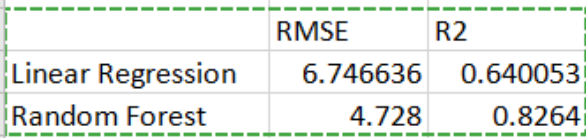